In [1]:
from mcmc import *
from fit import *
from process_showers import ProcessEvents
from config import CounterConfig
# from datafiles import *
import matplotlib.pyplot as plt
plt.ion()
from utils import plot_event, plot_generator, get_data_files, preceding_noise_file
data_date_and_time = '20190504034237'
data_files = get_data_files(data_date_and_time)
noise_files = [preceding_noise_file(f) for f in data_files]
cfg = CounterConfig(data_files, noise_files)

In [2]:
pars = [500.,2.e6,np.deg2rad(40.),np.deg2rad(315.), 450., -660.,-25.7,0,70]
ev = BasicParams.get_event(pars)
pe = ProcessEvents(cfg, frozen_noise=False)
real_nfits = pe.gen_nfits_from_event(ev)
pf = NichePlane(real_nfits)
ty = tyro(real_nfits)

In [3]:
guess = make_guess(ty,pf)

In [4]:
pt = PeakTimes(real_nfits, BasicParams, cfg)
pt.target_parameters = ['zenith','azimuth']
m = init_minuit(pt, guess)
m.tol = .1
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 28.63 (χ²/ndof = 3.6)      │              Nfcn = 61               │
│ EDM = 0.02 (Goal: 0.1)           │           time = 26.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    400    │    50     │            │            │   300   │   600   │  yes  │
│ 1 │ nmax     │   1.0e6   │   0.1e6   │            │            │ 100000  │  1e+07  │  yes  │
│ 2 │ zenith   │ 697.99e-3 │  0.18e-3  │            │            │0.617378 │0.817378 │       │
│ 3 │ azimuth  │  5.50458  │  0.00013  │            │            │ 5.35053 │ 5.55053 │       │
│ 4 │ corex    │    448    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │   -680    │     5     │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │   -25.7   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │    100    │    10     │            │            │    0    │   150   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now with a good estimate for the angles, we can fit the pulse widths to estimate xmax.

In [5]:
guess = update_guess_values(guess, m)
pw = PulseWidth(real_nfits, BasicParams, cfg)
pw.target_parameters = ['xmax']
m = init_minuit(pw, guess)
m.simplex(ncall=40)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 32.95 (χ²/ndof = 3.7)      │               Nfcn = 9               │
│ EDM = 0.0852 (Goal: 0.1)         │            time = 4.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    433    │    23     │            │            │   300   │   600   │       │
│ 1 │ nmax     │   1.0e6   │   0.1e6   │            │            │ 100000  │  1e+07  │  yes  │
│ 2 │ zenith   │   0.698   │   0.017   │            │            │0.617378 │0.817378 │  yes  │
│ 3 │ azimuth  │   5.505   │   0.017   │            │            │ 5.35053 │ 5.55053 │  yes  │
│ 4 │ corex    │    448    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │   -680    │     5     │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │   -25.7   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │    100    │    10     │            │            │    0    │   150   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now, with a good estimate for log(xmax), we can fit the integrated pulse areas for nmax.

In [6]:
guess = update_guess_values(guess, m)
pa = PulseArea(real_nfits, BasicParams, cfg)
pa.target_parameters = ['nmax']
m = init_minuit(pa, guess)
m.simplex(ncall=20)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 220.7 (χ²/ndof = 24.5)     │              Nfcn = 22               │
│ EDM = 0.0407 (Goal: 0.1)         │           time = 10.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    430    │    50     │            │            │   300   │   600   │  yes  │
│ 1 │ nmax     │  2.51e6   │  0.04e6   │            │            │ 100000  │  1e+07  │       │
│ 2 │ zenith   │   0.698   │   0.017   │            │            │0.617378 │0.817378 │  yes  │
│ 3 │ azimuth  │   5.505   │   0.017   │            │            │ 5.35053 │ 5.55053 │  yes  │
│ 4 │ corex    │    448    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │   -680    │     5     │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │   -25.7   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │    100    │    10     │            │            │    0    │   150   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now, with these values in the ballpark, we can simultaneously minimize both the shower profile and core position by fitting the normalized pulse areas.

In [7]:
guess = update_guess_values(guess, m)
pa = NormalizedPulseArea(real_nfits, BasicParams, cfg)
pa.target_parameters = ['xmax','nmax','corex','corey']
m = init_minuit(pa, guess)
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.337 (χ²/ndof = 1.1)      │              Nfcn = 112              │
│ EDM = 0.111 (Goal: 0.1)          │           time = 53.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    488    │    10     │            │            │   300   │   600   │       │
│ 1 │ nmax     │  2.11e6   │  0.10e6   │            │            │ 100000  │  1e+07  │       │
│ 2 │ zenith   │   0.698   │   0.017   │            │            │0.617378 │0.817378 │  yes  │
│ 3 │ azimuth  │   5.505   │   0.017   │            │            │ 5.35053 │ 5.55053 │  yes  │
│ 4 │ corex    │   449.8   │    1.1    │            │            │  379.5  │  489.2  │       │
│ 5 │ corey    │  -662.37  │   0.15    │            │            │ -711.4  │ -615.1  │       │
│ 6 │ corez    │   -25.7   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │    100    │    10     │            │            │    0    │   150   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [8]:
guess = update_guess(m)
at = AllSamples(real_nfits, BasicParams, cfg)
at.target_parameters = ['t_offset']
m = init_minuit(at, guess)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1880 (χ²/ndof = 9.4)       │              Nfcn = 74               │
│ EDM = 0.0078 (Goal: 0.0002)      │           time = 28.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    488    │    10     │            │            │   300   │   600   │  yes  │
│ 1 │ nmax     │  2.11e6   │  0.10e6   │            │            │ 100000  │  1e+07  │  yes  │
│ 2 │ zenith   │   0.698   │   0.017   │            │            │0.617378 │0.817378 │  yes  │
│ 3 │ azimuth  │   5.505   │   0.017   │            │            │ 5.35053 │ 5.55053 │  yes  │
│ 4 │ corex    │   449.8   │    1.1    │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │  -662.37  │   0.15    │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │   -25.7   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │ 77.113159 │ 0.000006  │            │            │    0    │   150   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│          │     xmax     nmax   zenith  azimuth    corex    corey    corez       x0   lambda t_offset │
├──────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│     xmax │        0        0        0        0        0        0        0        0        0        0 │
│     nmax │        0        0        0        0        0        0        0        0        0        0 │
│   zenith │        0        0        0        0        0        0        0        0        0        0 │
│  azimuth │        0        0        0        0        0        0        0        0        0        0 │
│    corex │        0        0        0        0        0        0        0        0        0        0 │
│    corey │        0        0        0        0        0        0        0        0        0        0 │
│    corez │        0        0        0        0        0        0        0        0        0        0 │
│       x0 │        0        0        0        0        0        0        0        0        0        0 │
│   lambda │        0        0        0        0        0        0        0        0        0        0 │
│ t_offset │        0        0        0        0        0        0        0        0        0 3.25e-11 │
└──────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [19]:
guess = update_guess_values(guess, m)
guessdict = {p.name:p for p in guess}
guessdict['zenith'].fixed = True
guessdict['azimuth'].fixed = True
guessdict['corex'].fixed = True
guessdict['corey'].fixed = True
guessdict['corez'].fixed = True
guessdict['x0'].fixed = True
guessdict['lambda'].fixed = True
guessdict['t_offset'].fixed = True

In [20]:
guess

[FitParam(name='xmax', value=487.7733885129443, limits=(300.0, 600.0), error=10.523576467057097, fixed=False),
 FitParam(name='nmax', value=2114609.1706683002, limits=(100000.0, 10000000.0), error=103349.67783026921, fixed=False),
 FitParam(name='zenith', value=0.6979870975380511, limits=(0.6173777608952201, 0.8173777608952201), error=0.017453292519943295, fixed=True),
 FitParam(name='azimuth', value=5.50458222962791, limits=(5.3505291225018405, 5.55052912250184), error=0.017453292519943295, fixed=True),
 FitParam(name='corex', value=449.8042051528076, limits=(379.5, 489.2), error=1.061221470241577, fixed=True),
 FitParam(name='corey', value=-662.3696839538798, limits=(-711.4, -615.1), error=0.15448663676221486, fixed=True),
 FitParam(name='corez', value=-25.7, limits=(None, None), error=1.0, fixed=True),
 FitParam(name='x0', value=0.0, limits=(None, None), error=1.0, fixed=True),
 FitParam(name='lambda', value=70.0, limits=(None, None), error=1.0, fixed=True),
 FitParam(name='t_offset

In [23]:
sampler, pos, prob, state = main(at,guess,niter=500,nwalkers=4)

100%|███████████████████████████████████████████████████████| 500/500 [08:31<00:00,  1.02s/it]


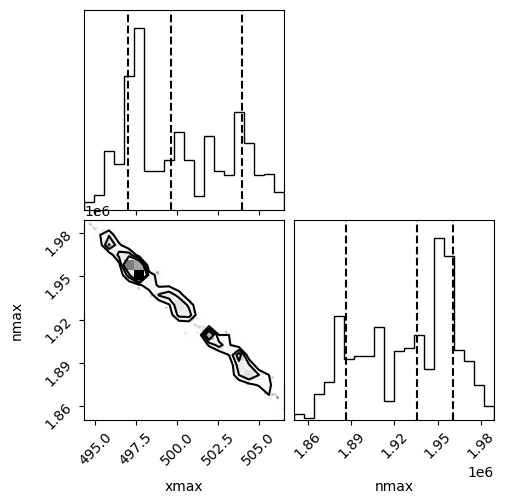

In [22]:
flat_samples = sampler.get_chain(discard=400,flat=True)
fig = corner.corner(flat_samples,labels=[p.name for p in guess if not p.fixed],quantiles=[0.16, 0.5, 0.84])

In [13]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]


array([4.92746712e+02, 2.03247743e+06, 6.99330336e-01, 5.49683755e+00])

In [14]:
pars

[500.0,
 2000000.0,
 0.6981317007977318,
 5.497787143782138,
 450.0,
 -660.0,
 -25.7,
 0,
 70]

In [15]:
guessdict = {p.name:p.value for p in guess}

In [16]:
np.array(list(guessdict.values()))

array([ 4.87773389e+02,  2.11460917e+06,  6.97987098e-01,  5.50458223e+00,
        4.49804205e+02, -6.62369684e+02, -2.57000000e+01,  0.00000000e+00,
        7.00000000e+01,  7.71131589e+01])